In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
class MyScaler(nn.Module):
    def __init__(self):
        super(MyScaler, self).__init__()
        
        self.mean_ = nn.Parameter(torch.zeros(1), requires_grad = False)
        self.scale_ = nn.Parameter(torch.ones(1), requires_grad = False)
    def fit(self, x):
        self.mean_.data = x.mean(0)
        self.scale_.data = x.std(0)
        return self
    def transform(self, x):
        return (x - self.mean_) / self.scale_

In [66]:
forward_model = lambda x: x**3 + 1e-3*x**5
# forward_model = torch.exp

inverse_model = nn.Sequential(nn.Linear(1, 4),
                              nn.LeakyReLU(),
                              nn.Linear(4, 4),
                              nn.LeakyReLU(),
                              nn.Linear(4, 4),
                              nn.LeakyReLU(),
                              nn.Linear(4, 1),
                              nn.LeakyReLU())

In [67]:
N = 100
nr_epochs = 10000
nr_prints = 10
lr = 1e-2
lambda_ = 0

In [68]:
x = torch.randn(N).view(-1, 1)
y = forward_model(x)

scaler = MyScaler()
scaler.fit(y)
y_norm = torch.Tensor(scaler.transform(y))

loss = nn.MSELoss()
optim = torch.optim.Adam(inverse_model.parameters(), lr=lr)

l_loss_x = []
l_loss_y = []
for i in range(nr_epochs):
    optim.zero_grad()
    x_inv = inverse_model(y_norm)
    y_pred = forward_model(x_inv)
    y_pred_norm = scaler.transform(y_pred)
    x_inv_2 = inverse_model(y_pred_norm)
    loss_x = loss(x_inv, x_inv_2)
    loss_y = loss(y_pred, y)
    MSE = loss_y + lambda_*loss_x
    MSE.backward()
    optim.step()
    l_loss_x.append(loss_x.detach())
    l_loss_y.append(loss_y.detach())
    if i % int(nr_epochs/nr_prints) == 0:
        print(f'iter: {i:10d}\t loss_x = {loss_x: .10f}\t loss_y = {loss_y: .10f}')

iter:          0	 loss_x =  0.0001721439	 loss_y =  5.0077371597
iter:       1000	 loss_x =  0.0254630074	 loss_y =  2.6760282516
iter:       2000	 loss_x =  0.0065676169	 loss_y =  0.0272472948
iter:       3000	 loss_x =  0.0058779698	 loss_y =  0.0216586180
iter:       4000	 loss_x =  0.0066349586	 loss_y =  0.0187364575
iter:       5000	 loss_x =  0.0026894922	 loss_y =  0.0041223704
iter:       6000	 loss_x =  0.0028687282	 loss_y =  0.0034437389
iter:       7000	 loss_x =  0.0029669625	 loss_y =  0.0037773962
iter:       8000	 loss_x =  0.0030105931	 loss_y =  0.0035972819
iter:       9000	 loss_x =  0.0030015728	 loss_y =  0.0035475483


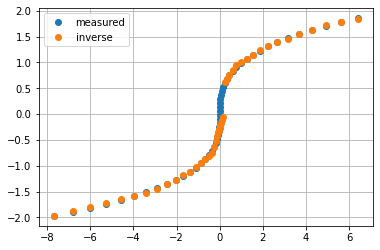

In [69]:
plt.figure()
x_np = x.cpu().numpy()
x_bins = np.linspace(np.percentile(x_np, 1), np.percentile(x_np, 99))
y_bins = forward_model(torch.Tensor(x_bins).view(-1, 1))
y_bins_norm = scaler.transform(y_bins)
x_inv = inverse_model(y_bins_norm).cpu().detach().numpy()
plt.plot(y_bins, x_bins, 'o', label = 'measured')
plt.plot(y_bins, x_inv, 'o', label = 'inverse')
plt.legend()
plt.grid()

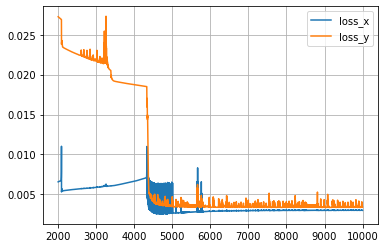

In [71]:
plt.figure()
forget_first = 2000
epochs = np.arange(nr_epochs)
plt.plot(epochs[forget_first:], l_loss_x[forget_first:], label = 'loss_x')
plt.plot(epochs[forget_first:], l_loss_y[forget_first:], label = 'loss_y')
plt.legend()
plt.grid(True)